# LangGraph 찍먹!

LangGraph는 **에이전트** 및 **멀티에이전트 워크플로우** 를 만드는 데 사용되는 LLM으로 **상태 저장**, **멀티액터** 애플리케이션을 구축하기 위한 라이브러리입니다. 

다른 LLM 프레임워크와 비교할 때 **주기(Cycle), 제어 가능성, 지속성** 이라는 핵심 이점을 제공합니다. LangGraph를 사용하면 대부분의 에이전트 아키텍처에 필수적인 **주기를 포함하는 플로우를 정의할 수 있어 DAG 기반 솔루션과 차별화** 됩니다. 

매우 낮은 수준의 프레임워크로서 애플리케이션의 흐름과 상태를 모두 세밀하게 제어할 수 있어 **안정적인 에이전트를 만드는 데 매우 중요** 합니다. 또한 LangGraph에는 지속성이 내장되어 있어 고급 휴먼 인 더 루프 및 메모리 기능을 사용할 수 있습니다.

LangGraph는 Pregel과 Apache Beam에서 영감을 받았습니다. 공용 인터페이스는 NetworkX에서 영감을 얻었습니다. LangGraph는 LangChain을 개발한 LangChain Inc에서 구축했지만, LangChain 없이도 사용할 수 있습니다.

## 환경설정

In [1]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


## 노드와 엣지

주요 개념

- GraphState(상태 저장 그래프): LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- Node(노드): 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- Edge(엣지): 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.


## GraphState

각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [3]:
from typing import TypedDict


# GraphState 요소는 상태를 전달하는 용도로 사용됩니다.
class GraphState(TypedDict):
    goal: str  # 목표
    todo: list[str]  # 할 일 목록
    current_job: str  # 현재 작업
    total_time: int  # 총 소요시간(시간)
    time_spent: int  # 소요 시간(시간)
    status: str  # 상태(진행중, 다음 작업, 종료)

## Node & Edge

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser
from rag.utils import format_task


def create_todo_list(goal):
    output_parser = CommaSeparatedListOutputParser()
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "당신은 나의 할일을 관리하는 비서입니다. 당신의 임무는 나를 위하여 주어진 목표에 대하여 할일 목록을 작성하는 것입니다.",
            ),
            (
                "human",
                "주어진 목표(goal)를 잘 수행하기 위하여 할일 목록을 작성해 주세요. `할일:걸리는시간(hour)` 으로 작성하세요. 걸리는 시간은 반올림하여 int 로 작성하세요.\n\n#목표: {goal}\n\n#형식: {format_instuctions}",
            ),
        ]
    )
    prompt = prompt.partial(format_instuctions=output_parser.get_format_instructions())
    llm = ChatOpenAI(model_name="gpt-4-turbo")
    chain = prompt | llm | CommaSeparatedListOutputParser()

    output = chain.invoke({"goal": goal})
    return output

In [5]:
todo = create_todo_list("LangChain 튜토리얼로 RAG 공부하기")
todo

['LangChain 공식 웹사이트 방문:1',
 'LangChain RAG 관련 문서 검색:1',
 'LangChain RAG 튜토리얼 다운로드:1',
 '튜토리얼 읽기 및 이해하기:3',
 '실습 환경 설정:2',
 '튜토리얼 실습하기:4',
 '추가 질문 정리 및 커뮤니티에 질문하기:2']

## 각 노드의 세부 기능 정의

In [6]:
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]
    # 리스트 작성
    todo = create_todo_list(goal)
    # 할 일 목록을 포맷팅
    todo = format_task(create_todo_list(todo))
    return GraphState(todo=todo)


def start_job(state: GraphState) -> GraphState:
    todo = state["todo"]
    if len(todo):
        current_job, total_time = todo.pop(0)
        status = "진행중"
        time_spent = 0
    return GraphState(
        current_job=current_job,
        total_time=total_time,
        status=status,
        time_spent=time_spent,
    )


def process_job(state: GraphState) -> GraphState:
    time_spent = state["time_spent"]
    time_spent += 1

    return GraphState(time_spent=time_spent)


def check_progress(state: GraphState) -> GraphState:
    if state["time_spent"] >= state["total_time"]:
        status = "다음 작업"
        if len(state["todo"]) == 0:
            status = "종료"
    else:
        status = "진행중"
    return GraphState(status=status)


def next_step(state: GraphState) -> GraphState:
    return state["status"]

## 그래프 정의

In [8]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# Todo 를 작성합니다.
workflow.add_node("list_todo", list_todo)  # 에이전트 노드를 추가합니다.

# Todo 작업을 시작합니다.
workflow.add_node("start_job", start_job)

# 작업을 진행합니다.
workflow.add_node("process_job", process_job)

# 작업을 중간 체크합니다.
workflow.add_node("check_progress", check_progress)

# 각 노드들을 연결합니다.
workflow.add_edge("list_todo", "start_job")
workflow.add_edge("start_job", "process_job")
workflow.add_edge("process_job", "check_progress")

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "check_progress",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    next_step,
    {
        "진행중": "process_job",  # 관련성이 있으면 종료합니다.
        "다음 작업": "start_job",  # 관련성이 없으면 다시 답변을 생성합니다.
        "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점을 설정합니다.
workflow.set_entry_point("list_todo")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

## 그래프 시각화

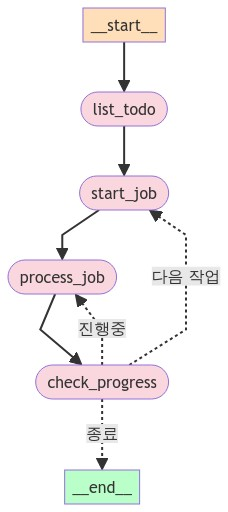

In [9]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [10]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(goal="랭체인(LangChain) 밋업에서 발표자료를 준비하기")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

'[NODE] list_todo'
("<todo> [('주제 선정 및 연구', 4), ('발표 구조 설계', 2), ('발표 슬라이드 제작', 3), ('스크립트 작성 및 "
 "연습', 3), ('발표 리허설', 2), ('최종 검토 및 수정', 1)]")
'=============================='
'[NODE] start_job'
'<current_job> 주제 선정 및 연구'
'<total_time> 4'
'<time_spent> 0'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 1'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 2'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 3'
'=============================='
'[NODE] check_progress'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 4'
'=============================='
'[NODE] check_progress'
'<status> 다음 작업'
'=============================='
'[NODE] start_job'
'<current_job> 발표 구조 설계'
'<total_time> 2'
'<time_spent> 0'
'<status> 진행중'
'==========================

## LangSmith 추적

- 추적: https://smith.langchain.com/public/d4857c97-bbb7-4776-8c90-c3908b77a38f/r